In [1]:
from IPython.display import HTML, display
css_file_path = "../../design/custom.css"
styles = "<link rel='stylesheet' href='%s'>" % css_file_path
display(HTML(styles))

# 1.3 $\quad$ Simulación de Montecarlo con un activo

In [2]:
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

plt.style.use('ggplot')

Vamos a generar simulaciones de Montecarlo de un activo a partir de su media y desviación estandar. Vamos a aprender a generar una simulación de precios. Luego, entraremos en detalle para generar N simulaciones de Montecarlo.

## 1. Generación de una simulación de precios

Primero vamos a generar los retornos para formar carteras de dos activos. Para ello, vamos a generar un rango de fechas para las simulaciones. Utilizaremos los días hábiles de la bolsa de Nueva York.

In [3]:
# Número de días
num_dias = 1000
start_date = "2010-01-01"
end_date = "2100-01-01"

nyse = mcal.get_calendar('XNYS') # Mercado de nueva york
schedule = nyse.schedule(start_date=start_date, end_date=end_date)
business_days = schedule.index[:num_dias]

Ahora definimos los parámetros de los activos. Debemos definir la media y desviación estandar del activo.

In [4]:
# Parámetros de los activos
media = 0.005 # Media del activo
std = 0.1  # Desviación estándar del activo

Podemos generar los retornos del activo generando números aleatorios usando una distribución normal.

**Observación**: Recuerda que los retornos no siguen una distribución normal

In [5]:
ret_df = [0.0] + list(np.random.normal(media, std, num_dias))
ret_df = np.array(ret_df)

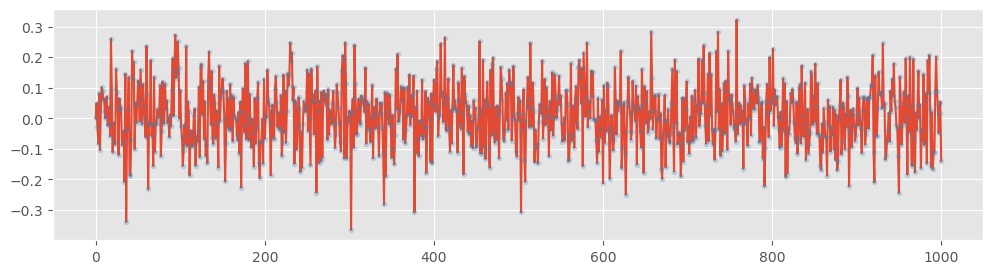

In [6]:
plt.figure(figsize=(12, 3))
plt.plot(ret_df)
plt.plot(ret_df, '.', alpha=0.2)
plt.show()

Para recuperar los precios del activo a partir de sus retornos, debemos invertir la transformación. Sabemos que:

$$r_t = log({P_t \over P_{t-1}}) = log(P_t) - log(P_{t-1})$$

donde $P_t$ y $P_{t-1}$ son los precios del activo a tiempo $t$ y $t-1$, respectivamente. Por tanto, aplicando las siguientes transformaciones:

- exp a ambos lados de la ecuación:

$$e^{r_t} = {P_t \over P_{t-1}}$$

- Por tanto:

$$P_t = P_{t-1} e^{r_t}$$

- Y generalizando:

$$P_t = P_0 e^{r_1 + r_2 + ... + r_t}$$

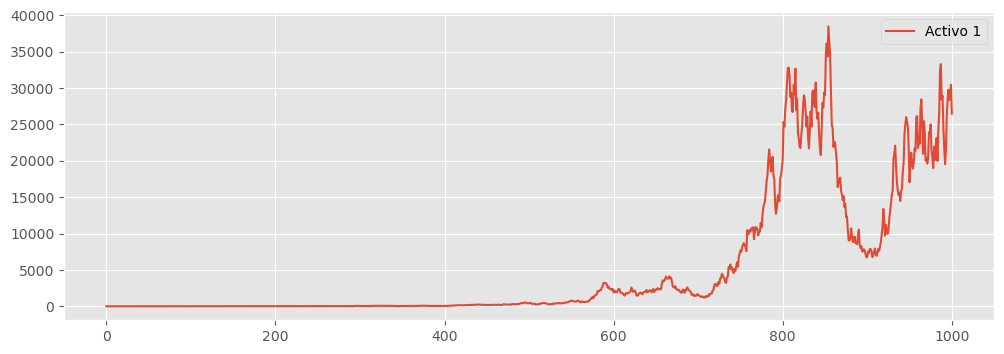

In [7]:
precio_ini = 1.0
precios_df = precio_ini * np.exp(ret_df.cumsum())

plt.figure(figsize=(12, 4))
plt.plot(precios_df, label="Activo 1")
plt.legend()
plt.show()

## 2. Montecarlo

Los métodos de Montecarlo o Experimentos de Montecarlo son una amplia clase de algoritmos computacionales que se utilizan para modelar la probabilidad de diferentes resultados en un proceso que no puede ser fácilmente modelado debido a la introducción de una variable aleatoria.

Básicamente, es un algoritmo de **fuerza bruta** para simular procesos aleatorios.


Primero, definimos la **media** y la **desviación** del activo.

In [8]:
# Parámetros de los activos
media = 0.001  # Media del activo
std = 0.01  # Desviación estándar del activo

Primero, generamos los retornos de **N** simulaciones con **D** días siguiendo la media y std que definimos previamente.

In [9]:
num_dias = 1000
num_simulaciones = 100
ret_df = np.concatenate((np.zeros(num_simulaciones)[:, None], np.random.normal(media, std, (num_simulaciones, num_dias))), axis=1)
ret_df.shape # (num_simulaciones, num_dias+1)

(100, 1001)

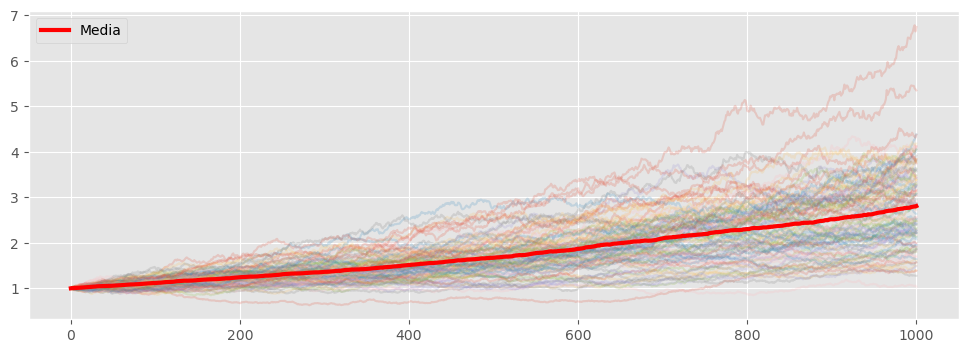

In [10]:
precio_ini = 1.0
precios_df = precio_ini * np.exp(ret_df.cumsum(axis=1))

plt.figure(figsize=(12, 4))
plt.plot(precios_df.T, alpha=0.2)
plt.plot(precios_df.mean(axis=0), linewidth=3, label="Media", color="red")
plt.legend()
plt.show()

**EJERCICIO:** Hagamos una simulación de Montecarlo del índice S&P 500 con los datos desde 2010 a 2018.

In [11]:
start = "2010-01-01"
end = "2018-01-01"
num_simulaciones = 100

precios = yf.download("SPY", start=start, end=end)["Adj Close"]
retornos = np.log(precios).diff().dropna()

media = retornos.mean()
std = retornos.std()
ret_df = np.concatenate((np.zeros(num_simulaciones)[:, None], np.random.normal(media, std, (num_simulaciones, len(retornos)))), axis=1)
ret_df.shape # (num_simulaciones, num_dias+1)

[*********************100%%**********************]  1 of 1 completed


(100, 2013)

Pintamos todas nuestras simulaciones con un `alpha=0.2`, la media de las simulaciones y el precio real del S&P 500.

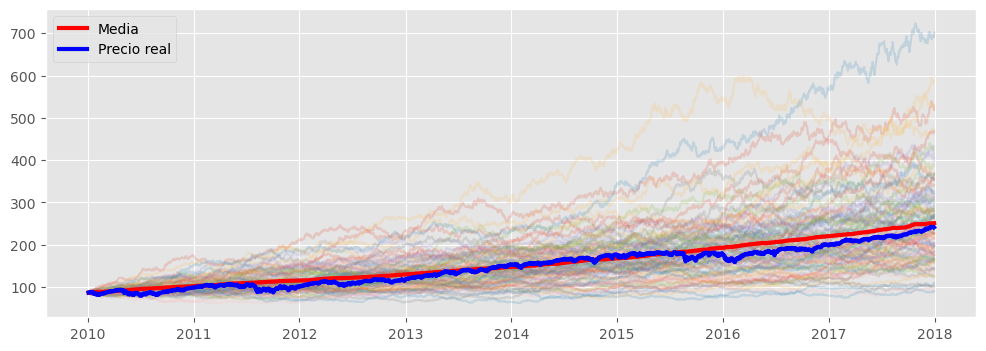

In [12]:
precio_ini = precios[0]
precios_df = precio_ini * np.exp(ret_df.cumsum(axis=1))

plt.figure(figsize=(12, 4))
plt.plot(precios.index, precios_df.T, alpha=0.2)
plt.plot(precios.index, precios_df.mean(axis=0), linewidth=3, label="Media", color="red")
plt.plot(precios, linewidth=3, label="Precio real", color="blue")
plt.legend()
plt.show()

Pintamos ahora todas nuestras simulaciones con un `alpha=0.05`, la media, mediana, percentil 5 y 95 y el precio real del S&P 500.

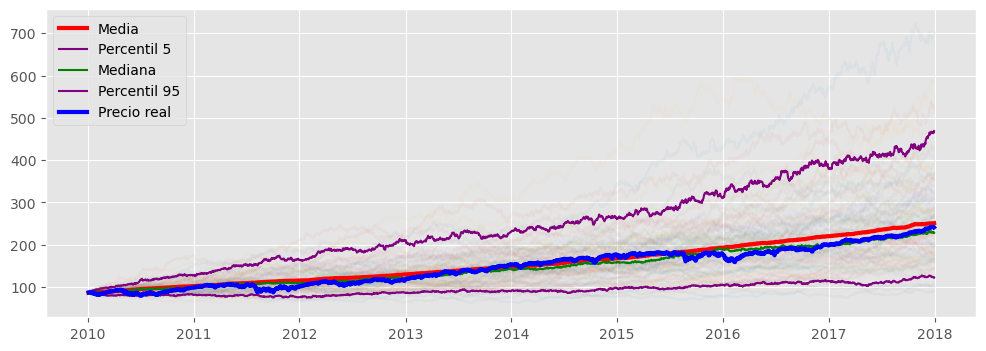

In [13]:
precio_ini = precios[0]
precios_df = precio_ini * np.exp(ret_df.cumsum(axis=1))

plt.figure(figsize=(12, 4))
plt.plot(precios.index, precios_df.T, alpha=0.05)
plt.plot(precios.index, precios_df.mean(axis=0), linewidth=3, label="Media", color="red")
plt.plot(precios.index, np.percentile(precios_df, 5, axis=0), label="Percentil 5", color="purple")
plt.plot(precios.index, np.percentile(precios_df, 50, axis=0), label="Mediana", color="green")
plt.plot(precios.index, np.percentile(precios_df, 95, axis=0), label="Percentil 95", color="purple")
plt.plot(precios, linewidth=3, label="Precio real", color="blue")
plt.legend()
plt.show()

Sin embargo, **hemos hecho trampas**. Hemos utilizado datos históricos para simular esos mismos datos históricos. Vamos a modificar el código anterior para generar datos a partir de 2018.

In [14]:
start = "2010-01-01"
end = "2018-01-01"
num_simulaciones = 100

precios_old = yf.download("SPY", start=start, end=end)["Adj Close"]
precios_new = yf.download("SPY", start=end)["Adj Close"] # Usaremos precios_new para pintar el dato real
retornos_old = np.log(precios_old).diff().dropna()

media = retornos_old.mean() # La media de los retornos_old
std = retornos_old.std() # La std de los retornos_old
ret_df = np.random.normal(media, std, (num_simulaciones, len(precios_new)))
ret_df.shape

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(100, 1517)

Volvemos a pintar todas nuestras simulaciones a partir de 2018 con un `alpha=0.2` y la media de las simulaciones.

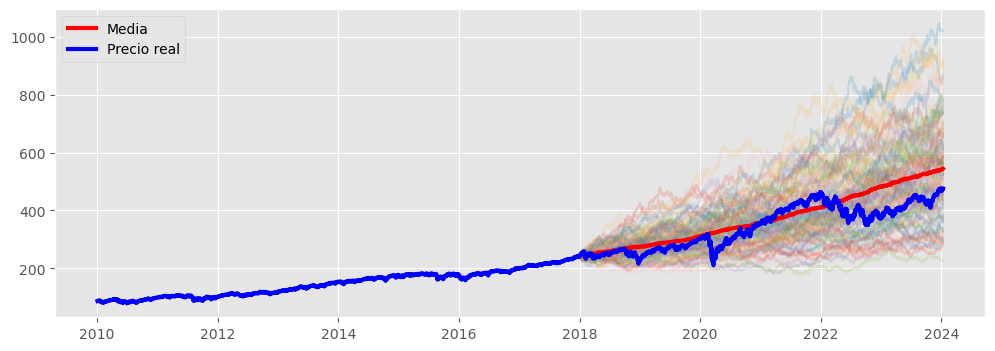

In [15]:
precio_ini = precios_new[0] # OJO! el precio inicial es el precio_new[0]
precios_df = precio_ini * np.exp(ret_df.cumsum(axis=1))

plt.figure(figsize=(12, 4))
plt.plot(precios_new.index, precios_df.T, alpha=0.2)
plt.plot(precios_new.index, precios_df.mean(axis=0), linewidth=3, label="Media", color="red")
plt.plot(precios_old, linewidth=3, color="blue")
plt.plot(precios_new, linewidth=3, label="Precio real", color="blue")
plt.legend()
plt.show()

Como antes, pintamos también la mediana y los percentiles 5 y 95.

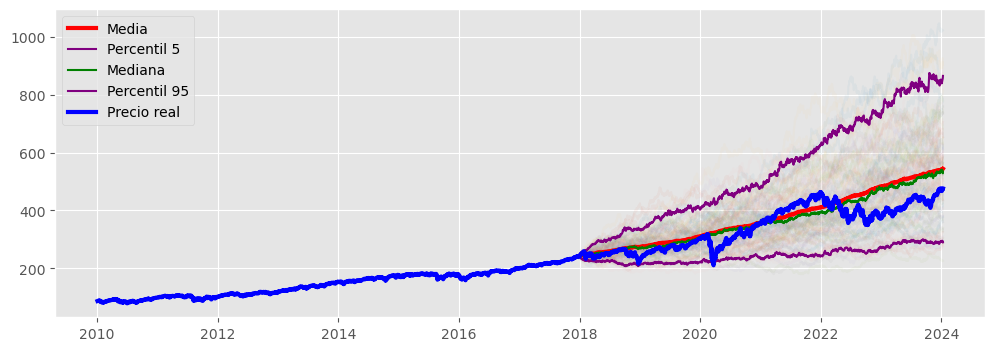

In [16]:
precio_ini = precios_new[0]
precios_df = precio_ini * np.exp(ret_df.cumsum(axis=1))

plt.figure(figsize=(12, 4))
plt.plot(precios_new.index, precios_df.T, alpha=0.05)
plt.plot(precios_new.index, precios_df.mean(axis=0), linewidth=3, label="Media", color="red")
plt.plot(precios_new.index, np.percentile(precios_df, 5, axis=0), label="Percentil 5", color="purple")
plt.plot(precios_new.index, np.percentile(precios_df, 50, axis=0), label="Mediana", color="green")
plt.plot(precios_new.index, np.percentile(precios_df, 95, axis=0), label="Percentil 95", color="purple")
plt.plot(precios_old, linewidth=3, color="blue")
plt.plot(precios_new, linewidth=3, label="Precio real", color="blue")
plt.legend()
plt.show()

**Discusión:** ¿Qué está sucediendo? ¿Qué puedes comentar de los resultados?